# TC 5033

# Deep Learning
# Activity 2B
# Team 35:

- Ruben Díaz Garcia - A01371849
- Francisco Antonio Enríquez Cabrera - A01795006
- Jorge Arturo Hernández Morales
- Elmer Jiménez Hernández 
- Kurt Yañez Badelt - A00394053
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt

### Download the dataset

In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = 'Activity 2c/data'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Using GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Show a random Image

The shown image is: Cat


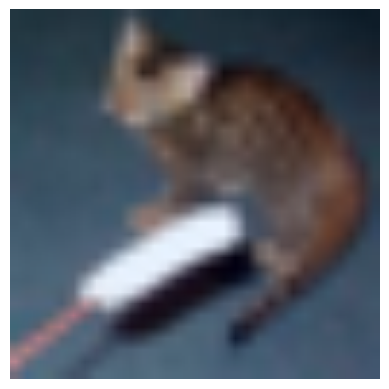

In [6]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'The shown image is: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calculate Accuracy

In [7]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   



### Show Predicted Image

In [8]:
def show_prediction(model, dataset, index, classes, mean, std):
    model.eval()
    model = model.to(device)
    image, label = dataset[index]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_input)
        _, predicted = torch.max(output, 1)
    image_display = image.cpu().numpy().transpose((1, 2, 0))
    image_display = std * image_display + mean
    image_display = np.clip(image_display, 0, 1)
    plt.imshow(image_display)
    plt.title(f'True Label: {classes[label]}\nPredicted: {classes[predicted.item()]}')
    plt.axis('off')
    plt.show()

### Load RestNet18 Pre-Trained Model

In [9]:
model_resnet18 = models.resnet18(pretrained=True)

/home/kurt/Documents/MNA/Advanced_ML/itesm_advancedml_e35/venv_aml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kurt/Documents/MNA/Advanced_ML/itesm_advancedml_e35/venv_aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Explore RestNet18

In [10]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [11]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Adjust Restnet to work with our dataset

In [12]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [14]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [16]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Training Loop

In [17]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    print('Training the model on {}'.format(device))
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [18]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [19]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
train(model1, optimiser, epochs)

Training the model on cuda
Epoch: 0, costo: 0.6087650656700134, accuracy: 0.774,
Epoch: 1, costo: 1.0587048530578613, accuracy: 0.7914,
Epoch: 2, costo: 0.7582309246063232, accuracy: 0.7998,


Test Accuracy on CIFAR-10 with RestNet18: 0.7958


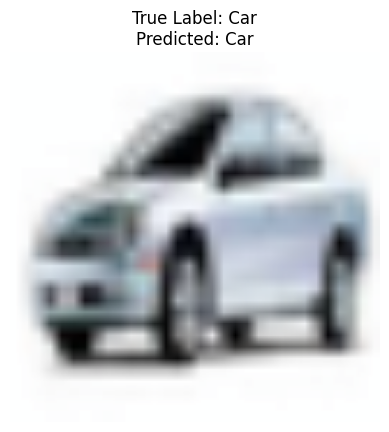

In [21]:
accuracy(model1, test_loader)

# Evaluate the model
test_accuracy = accuracy(model1, test_loader)
print(f'Test Accuracy on CIFAR-10 with RestNet18: {test_accuracy:.4f}')

# Display an image with its prediction
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

index = np.random.randint(len(cifar10_test))
show_prediction(model1, cifar10_test, index, classes, mean, std)

___
## Using ALEXNET

In [22]:
model_alexnet = models.alexnet(pretrained=True)

# Freeze all the parameters in the feature extractor
for param in model_alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier to match CIFAR-10 classes
num_classes = 10  # CIFAR-10 has 10 classes
model_alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Update transformations
transform_alexnet = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet mean
                std=(0.229, 0.224, 0.225))    # ImageNet std
])

/home/kurt/Documents/MNA/Advanced_ML/itesm_advancedml_e35/venv_aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:

# Update data loaders
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                 transform=transform_alexnet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                               transform=transform_alexnet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                transform=transform_alexnet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Training the model on cuda
Epoch: 0, costo: 0.4612891674041748, accuracy: 0.7974,
Epoch: 1, costo: 0.2756815552711487, accuracy: 0.8358,
Epoch: 2, costo: 0.22982823848724365, accuracy: 0.8354,
Test Accuracy on CIFAR-10 with AlexNet: 0.8288


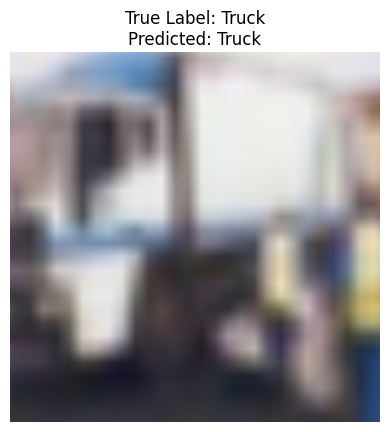

In [25]:


# Define optimizer
lr = 5e-4
optimizer = torch.optim.Adam(model_alexnet.classifier.parameters(), lr=lr)

# Train the model
epochs = 3
train(model_alexnet, optimizer, epochs)

# Evaluate the model
test_accuracy = accuracy(model_alexnet, test_loader)
print(f'Test Accuracy on CIFAR-10 with AlexNet: {test_accuracy:.4f}')

# Display an image with its prediction
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

index = np.random.randint(len(cifar10_test))
show_prediction(model_alexnet, cifar10_test, index, classes, mean, std)


___
## Using RestNet 50

In [26]:
# Load pre-trained ResNet50 model
model_resnet50 = models.resnet50(pretrained=True)

# Freeze all the parameters in the feature extractor
for param in model_resnet50.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match CIFAR-10 classes
num_classes = 10  # CIFAR-10 has 10 classes
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)

/home/kurt/Documents/MNA/Advanced_ML/itesm_advancedml_e35/venv_aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Update transformations
transform_resnet50 = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet mean
                std=(0.229, 0.224, 0.225))    # ImageNet std
])

In [28]:


# Update data loaders
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                 transform=transform_resnet50)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                               transform=transform_resnet50)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                                transform=transform_resnet50)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [29]:
# Define optimizer
lr = 5e-4
optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=lr)

# Train the model
epochs = 3
train(model_resnet50, optimizer, epochs)

# Evaluate the model
test_accuracy = accuracy(model_resnet50, test_loader)
print(f'Test Accuracy on CIFAR-10 with ResNet50: {test_accuracy:.4f}')

Training the model on cuda
Epoch: 0, costo: 1.049167513847351, accuracy: 0.7976,
Epoch: 1, costo: 0.8657385110855103, accuracy: 0.8024,
Epoch: 2, costo: 0.43837982416152954, accuracy: 0.805,
Test Accuracy on CIFAR-10 with ResNet50: 0.8066


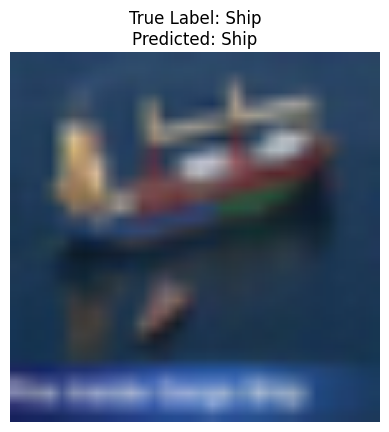

In [30]:




# Display an image with its prediction
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

index = np.random.randint(len(cifar10_test))
show_prediction(model_resnet50, cifar10_test, index, classes, mean, std)


___
## Using MobileNetV2

In [31]:
# Load MobileNetV2 pre-trained model
model_mobilenetv2 = models.mobilenet_v2(pretrained=True)

# Freeze feature extraction layers
for param in model_mobilenetv2.features.parameters():
    param.requires_grad = False

# Modify the classifier to match CIFAR-10 classes
num_classes = 10
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.last_channel, num_classes)

# Update transformations
transform_mobilenetv2 = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

/home/kurt/Documents/MNA/Advanced_ML/itesm_advancedml_e35/venv_aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:

# Update data loaders
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                 transform=transform_mobilenetv2)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                               transform=transform_mobilenetv2)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                                transform=transform_mobilenetv2)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [33]:



# Define optimizer
optimizer = torch.optim.Adam(model_mobilenetv2.classifier.parameters(), lr=lr)

# Train the model
train(model_mobilenetv2, optimizer, epochs)

# Evaluate the model
test_accuracy = accuracy(model_mobilenetv2, test_loader)
print(f'Test Accuracy on CIFAR-10 with MobileNetV2: {test_accuracy:.4f}')




Training the model on cuda
Epoch: 0, costo: 0.5606060028076172, accuracy: 0.7544,
Epoch: 1, costo: 1.0655944347381592, accuracy: 0.7644,
Epoch: 2, costo: 0.5720733404159546, accuracy: 0.7756,
Test Accuracy on CIFAR-10 with MobileNetV2: 0.7766


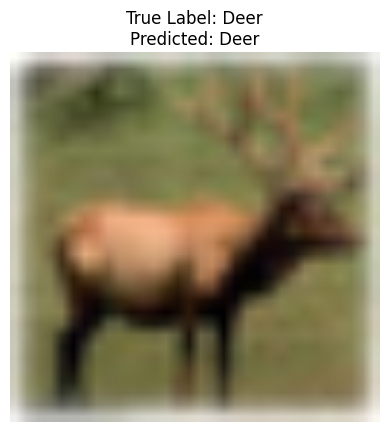

In [34]:
# Display an image with its prediction
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

index = np.random.randint(len(cifar10_test))
show_prediction(model_mobilenetv2, cifar10_test, index, classes, mean, std)

In this activity, we delved into the concept of Transfer Learning by applying various pre-trained models to the CIFAR-10 dataset. We began by examining a provided solution that utilized a pre-trained ResNet-18 model. Building upon this foundation, we selected three additional pre-trained models from PyTorch's model zoo: AlexNet, ResNet-50, and MobileNetV2. Our objective was to implement Transfer Learning with these models and evaluate their performance on the CIFAR-10 dataset.

For each model, we performed the following steps:

- Model Loading and Modification: Loaded the pre-trained model and adjusted its architecture to suit the CIFAR-10 classification task by modifying the final fully connected layers to output ten classes.

- Freezing Feature Extractors: Set requires_grad = False for the parameters of the feature extractor layers to leverage the pre-trained features without updating them during training.

- Data Transformation: Updated the data transformations to match each model's expected input size and normalization parameters, ensuring compatibility with the pre-trained weights.

- Training: Trained the modified classifier layers for a limited number of epochs using the CIFAR-10 training set, focusing on the new layers added.

- Evaluation: Assessed the models' performance by calculating accuracy on the validation and test sets.

- Visualization: Displayed sample images from the test set alongside the true labels and the models' predictions to qualitatively evaluate their performance.

- Model Depth and Performance: The deeper architecture of ResNet-50 resulted in the highest accuracy among the models tested. This suggests that models with greater depth and complexity can capture more intricate features, leading to better performance on classification tasks.

- Efficiency of MobileNetV2: Despite being designed for efficiency with fewer parameters, MobileNetV2 achieved an accuracy comparable to AlexNet. This highlights its suitability for deployment in environments with limited computational resources without significant loss in performance.

- Importance of Data Preprocessing: Adapting the input data to match the expected input size and normalization parameters of each pre-trained model was crucial. Mismatches in these parameters could lead to suboptimal performance due to the models' reliance on the statistical properties of the data they were originally trained on.